In [33]:
## In this example, we will study output data frame from pandora.py configuration
#### 1. Opening each data frame and check structure
#### 2. Collect POT and scale factor to the target POT
#### 3. Merge evtdf and mcnudf for further study
#### 4. Draw some plots for each slice and for each pfp

import os
import sys

import numpy as np
import math
import uproot as uproot
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import gridspec

# Add the head direcoty to sys.path
workspace_root = os.getcwd()  
sys.path.insert(0, workspace_root + "/../../")

# import this repo's classes
import pyanalib.pandas_helpers as ph


In [34]:
## 1. Open each df
venv_path = os.getenv("PATH")
evtdf = pd.read_hdf('../../test_pandoradf.df', key='evt')
hdrdf = pd.read_hdf('../../test_pandoradf.df', key='hdr')
mcnudf = pd.read_hdf('../../test_pandoradf.df', key='mcnu')

In [35]:
#### 1.1 Check evtdf structure
evtdf

slc              \
                                             is_clear_cosmic      vertex   
                                                                       x   
                                                                           
                                                                           
                                                                           
entry rec.slc..index rec.slc.reco.pfp..index                               
0     0              0                                     0  102.638908   
      1              0                                     0  -92.300949   
      2              0                                     0  138.153442   
      3              0                                     0 -173.046448   
1     1              0                                     0  103.660759   
..                                                       ...         ...   
31    1              1                                     0 -137.607483   
32    1              0                                     0 -103.921959   
33    0              0                                     0 -194.251678   
34    0              0                                     0  171.482239   
35    1              0                                     0  177.027847   

                                                                           \
                                                                     self   
                                                       y           z        
                                                                            
                                                                            
                                                                            
entry rec.slc..index rec.slc.reco.pfp..index                                
0     0              0                        109.219223   41.582222   51   
      1              0                        -45.653687   54.272339   49   
      2              0                        -51.999249  128.717682   50   
      3              0                       -127.580139  374.097107   48   
1     1              0                         52.811253  249.839478   57   
..                                                   ...         ...  ...   
31    1              1                        -73.764954  203.495361   27   
32    1              0                         20.248554  105.550026   61   
33    0              0                         95.053398    4.242520   45   
34    0              0                         73.112938   88.223305   58   
35    1              0                        -69.517517    4.236981   32   

                                                                       \
                                                tmatch                  
                                                   eff       pur  idx   
                                                                        
                                                                        
                                                                        
entry rec.slc..index rec.slc.reco.pfp..index                            
0     0              0                             NaN       NaN -999   
      1              0                        0.559507  0.993559    0   
      2              0                             NaN       NaN -999   
      3              0                        0.283503  0.993200    0   
1     1              0                             NaN       NaN -999   
..                                                 ...       ...  ...   
31    1              1                        0.913996  0.989320    0   
32    1              0                             NaN       NaN -999   
33    0              0                             NaN       NaN -999   
34    0              0                             NaN       NaN -999   
35    1              0                        0.900765  0.96

In [36]:
evtdf.slc.columns

MultiIndex([('is_clear_cosmic',              '',       '',  '', ''),
            (         'vertex',             'x',       '',  '', ''),
            (         'vertex',             'y',       '',  '', ''),
            (         'vertex',             'z',       '',  '', ''),
            (           'self',              '',       '',  '', ''),
            (         'tmatch',           'eff',       '',  '', ''),
            (         'tmatch',           'pur',       '',  '', ''),
            (         'tmatch',           'idx',       '',  '', ''),
            (       'producer',              '',       '',  '', ''),
            (           'nuid', 'crlongtrkdiry',       '',  '', ''),
            (       'nu_score',              '',       '',  '', ''),
            (          'truth',             'E',       '',  '', ''),
            (          'truth',          'time',       '',  '', ''),
            (          'truth',      'bjorkenX',       '',  '', ''),
            (          'truth', 'i

In [37]:
evtdf.pfp.columns

MultiIndex([(              'trk',      'producer',            '', ...),
            (              'trk',         'start',           'x', ...),
            (              'trk',         'start',           'y', ...),
            (              'trk',         'start',           'z', ...),
            (              'trk',           'end',           'x', ...),
            (              'trk',           'end',           'y', ...),
            (              'trk',           'end',           'z', ...),
            (              'trk',           'dir',           'x', ...),
            (              'trk',           'dir',           'y', ...),
            (              'trk',           'dir',           'z', ...),
            (              'trk',           'len',            '', ...),
            (              'trk',        'rangeP',      'p_muon', ...),
            (              'trk',          'mcsP',   'fwdP_muon', ...),
            (              'trk',        'rangeP',      'p_pion'

In [38]:
#### 1.2 Check hdrdf structure
hdrdf

,pot,first_in_subrun,ismc,run,subrun,ngenevt,evt,proc,cluster,fno
entry,,,,,,,,,,
0,7.890236e+14,1,1,1,1540,50,1,0,75017301,0
1,0.000000e+00,0,1,1,1540,50,8,0,75017301,0
2,0.000000e+00,0,1,1,1540,50,19,0,75017301,0
3,0.000000e+00,0,1,1,1540,50,20,0,75017301,0
4,0.000000e+00,0,1,1,1540,50,23,0,75017301,0
5,0.000000e+00,0,1,1,1540,50,30,0,75017301,0
6,0.000000e+00,0,1,1,1540,50,40,0,75017301,0
7,8.294677e+14,1,1,1,1519,50,4,0,75017301,1
8,0.000000e+00,0,1,1,1519,50,17,0,75017301,1


In [39]:
#### 1.3 Check mcnudf structure
mcnudf

E      time  bjorkenX inelasticityY        Q2  \
                                                                               
                                                                               
entry rec.mc.nu..index                                                         
0     0                 1.233148  1.855258  0.275538      0.520265  0.331955   
      1                 0.395337  1.528921  1.270619      0.212209  0.200173   
1     0                 1.042815  0.919271  0.238042      0.665278  0.310115   
2     0                 1.037469  1.454758  1.630262      0.148385  0.471282   
      1                 0.432981  0.489100  0.709336      0.336214  0.193907   
...                          ...       ...       ...           ...       ...   
53    0                 1.335640  1.050285  0.735852      0.540277  0.997137   
54    0                 1.917219  0.405634  0.571804      0.113874  0.234423   
55    0                 0.345686  1.668949  0.396716      0.421931  0.108658   
56    0                 1.084290  1.111336  0.955028      0.143419  0.278885   
      1                 2.562546  0.604992  0.165001      0.466553  0.370441   

                               w  momentum                        position  \
                                         x         y         z           x   
                                                                             
entry rec.mc.nu..index                                                       
0     0                 1.324525 -0.003902 -0.002823  1.233138 -115.329231   
      1                 0.915934  0.031001  0.009256  0.394011  558.635498   
1     0                 1.369023 -0.002897 -0.002796  1.042807  -92.365173   
2     0                 0.836284  0.015465  0.018319  1.037192   92.818176   
      1                 0.980319  0.013634 -0.014754  0.432515  268.725342   
...                          ...       ...       ...       ...         ...   
53    0                 1.113333  0.047389 -0.062153  1.333351  323.657166   
54    0                 1.028162  0.076056 -0.022352  1.915579  324.559845   
55    0                 1.023134 -0.001261 -0.001737  0.345679  -21.509834   
56    0                 0.945886 -0.013141 -0.007637  1.084184 -203.213974   
      1                 1.660182  0.098243  0.082185  2.559343  317.823242   

                        ...         p                                  \
                        ...      genp                           start   
                        ...         x         y         z           x   
entry rec.mc.nu..index  ...                                             
0     0                 ... -0.104121  0.068708  0.120867 -115.329231   
      1                 ...       NaN       NaN       NaN         NaN   
1     0                 ...  0.176741  0.197864  0.067511  -92.365173   
2     0                 ...  0.063048 -0.534579  0.136902   92.818176   
      1                 ...       NaN       NaN       NaN         NaN   
...                     ...       ...       ...       ...         ...   
53    0                 ...       NaN       NaN       NaN         NaN   
54    0                 ...       NaN       NaN       NaN         NaN   
55    0                 ...  0.198609  0.154166  0.400893  -21.509834   
56    0                 ...       NaN       NaN       NaN         NaN   
      1                 ...       NaN       NaN       NaN         NaN   

                                                                        \
                                                       end               
                                 y           z           x           y   
entry rec.mc.nu..index                                                   
0     0                 -25.000067  346.498383 -115.389053  -24.965239   
      1                        NaN         NaN         NaN         NaN   
1     0                 -45.260670   52.040985  -91.315514  -44.206432   
2     0                 174.394852  246.91604

In [40]:
mcnudf.columns

MultiIndex([(            'E',       '',  ''),
            (         'time',       '',  ''),
            (     'bjorkenX',       '',  ''),
            ('inelasticityY',       '',  ''),
            (           'Q2',       '',  ''),
            (            'w',       '',  ''),
            (     'momentum',      'x',  ''),
            (     'momentum',      'y',  ''),
            (     'momentum',      'z',  ''),
            (     'position',      'x',  ''),
            (     'position',      'y',  ''),
            (     'position',      'z',  ''),
            (          'pdg',       '',  ''),
            (         'iscc',       '',  ''),
            (   'genie_mode',       '',  ''),
            (   'parent_pdg',       '',  ''),
            ( 'parent_dcy_E',       '',  ''),
            ('max_proton_ke',       '',  ''),
            (           'nn',       '',  ''),
            (           'np',       '',  ''),
            (          'nmu',       '',  ''),
            (          'npi',     

In [41]:
## 2. Collect POT and scale factor to the target POT
this_pot = sum(hdrdf.pot)
print(this_pot)
target_POT = 3.0e18
POT_scale = target_POT / this_pot
print(POT_scale)

7572111631581184.0
396.19067255794664


In [42]:
evtdf.reset_index()

entry rec.slc..index rec.slc.reco.pfp..index             slc              \
                                                is_clear_cosmic      vertex   
                                                                          x   
                                                                              
                                                                              
                                                                              
0      0              0                       0               0  102.638908   
1      0              1                       0               0  -92.300949   
2      0              2                       0               0  138.153442   
3      0              3                       0               0 -173.046448   
4      1              1                       0               0  103.660759   
..   ...            ...                     ...             ...         ...   
69    31              1                       1               0 -137.607483   
70    32              1                       0               0 -103.921959   
71    33              0                       0               0 -194.251678   
72    34              0                       0               0  171.482239   
73    35              1                       0               0  177.027847   

                                                     ...       pfp  \
                           self    tmatch            ...       trk   
             y           z            eff       pur  ...     truth   
                                                     ...         p   
                                                     ...      genp   
                                                     ...         z   
0   109.219223   41.582222   51       NaN       NaN  ...       NaN   
1   -45.653687   54.272339   49  0.559507  0.993559  ...  0.195695   
2   -51.999249  128.717682   50       NaN       NaN  ...  0.064259   
3  -127.580139  374.097107   48  0.283503  0.993200  ...  0.508855   
4    52.811253  249.839478   57       NaN       NaN  ... -0.420308   
..         ...         ...  ...       ...       ...  ...       ...   
69  -73.764954  203.495361   27  0.913996  0.989320  ...  0.012935   
70   20.248554  105.550026   61       NaN       NaN  ...       NaN   
71   95.053398    4.242520   45       NaN       NaN  ...       NaN   
72   73.112938   88.223305   58       NaN       NaN  ... -0.507620   
73  -69.517517    4.236981   32  0.900765  0.964544  ...  1.650783   

                                                                          \
                                                                           
                                                                           
                                                                           
        length        G4ID      parent cont_tpc      genE interaction_id   
                                                                           
0          NaN -2147483648  4294967295        0       NaN    -2147483648   
1    99.259285    10000001    10000000        1  0.349053              0   
2     0.000000    20000127    20000000        0  4.120703             -1   
3    19.793539    10002400    10001534        1  1.107034              0   
4     0.000000    20000154    20000000        0  0.784975             -1   
..         ...         ...         ...      ...       ...            ...   
69   31.017580    10000035    10000000        1  0.248619              0   
70         NaN -2147483648  4294967295        0       NaN    -2147483648   
71         NaN -2147483648  4294967295        0       NaN    -2147483648   
72    0.000000    20000112    20000000        0  0.822541             -1   
73  139.603897    10000001    10000000        0  1.698898              0   

                                      
           shw tindex dist_to_vertex  
           len                        
                                      
                   

In [43]:
evtdf.slc.tmatch.idx.value_counts()

idx
 0      29
-999    23
 1      22
Name: count, dtype: int64

In [44]:
mcnudf.reset_index()

entry rec.mc.nu..index         E      time  bjorkenX inelasticityY  \
                                                                        
                                                                        
0      0                0  1.233148  1.855258  0.275538      0.520265   
1      0                1  0.395337  1.528921  1.270619      0.212209   
2      1                0  1.042815  0.919271  0.238042      0.665278   
3      2                0  1.037469  1.454758  1.630262      0.148385   
4      2                1  0.432981  0.489100  0.709336      0.336214   
..   ...              ...       ...       ...       ...           ...   
83    53                0  1.335640  1.050285  0.735852      0.540277   
84    54                0  1.917219  0.405634  0.571804      0.113874   
85    55                0  0.345686  1.668949  0.396716      0.421931   
86    56                0  1.084290  1.111336  0.955028      0.143419   
87    56                1  2.562546  0.604992  0.165001      0.466553   

          Q2         w  momentum            ...         p                      \
                               x         y  ...      genp                       
                                            ...         x         y         z   
0   0.331955  1.324525 -0.003902 -0.002823  ... -0.104121  0.068708  0.120867   
1   0.200173  0.915934  0.031001  0.009256  ...       NaN       NaN       NaN   
2   0.310115  1.369023 -0.002897 -0.002796  ...  0.176741  0.197864  0.067511   
3   0.471282  0.836284  0.015465  0.018319  ...  0.063048 -0.534579  0.136902   
4   0.193907  0.980319  0.013634 -0.014754  ...       NaN       NaN       NaN   
..       ...       ...       ...       ...  ...       ...       ...       ...   
83  0.997137  1.113333  0.047389 -0.062153  ...       NaN       NaN       NaN   
84  0.234423  1.028162  0.076056 -0.022352  ...       NaN       NaN       NaN   
85  0.108658  1.023134 -0.001261 -0.001737  ...  0.198609  0.154166  0.400893   
86  0.278885  0.945886 -0.013141 -0.007637  ...       NaN       NaN       NaN   
87  0.370441  1.660182  0.098243  0.082185  ...       NaN       NaN       NaN   

                                                                           ind  
         start                                 end                              
             x           y           z           x           y           z      
0  -115.329231  -25.000067  346.498383 -115.389053  -24.965239  346.567352   0  
1          NaN         NaN         NaN         NaN         NaN         NaN   1  
2   -92.365173  -45.260670   52.040985  -91.315514  -44.206432   52.367081   0  
3    92.818176  174.394852  246.916046   95.174629  158.649734  251.043579   0  
4          NaN         NaN         NaN         NaN         NaN         NaN   1  
..         ...         ...         ...         ...         ...         ...  ..  
83         NaN         NaN         NaN         NaN         NaN         NaN   0  
84         NaN         NaN         NaN         NaN         NaN         NaN   0  
85  -21.509834  -17.520947  438.197968  -17.222044  -13.968345  446.124603   0  
86         NaN         NaN         NaN         NaN         NaN         NaN   0  
87         NaN         NaN         NaN         NaN         NaN         NaN   1  

[88 rows x 59 columns]

In [45]:
mcnudf.columns

MultiIndex([(            'E',       '',  ''),
            (         'time',       '',  ''),
            (     'bjorkenX',       '',  ''),
            ('inelasticityY',       '',  ''),
            (           'Q2',       '',  ''),
            (            'w',       '',  ''),
            (     'momentum',      'x',  ''),
            (     'momentum',      'y',  ''),
            (     'momentum',      'z',  ''),
            (     'position',      'x',  ''),
            (     'position',      'y',  ''),
            (     'position',      'z',  ''),
            (          'pdg',       '',  ''),
            (         'iscc',       '',  ''),
            (   'genie_mode',       '',  ''),
            (   'parent_pdg',       '',  ''),
            ( 'parent_dcy_E',       '',  ''),
            ('max_proton_ke',       '',  ''),
            (           'nn',       '',  ''),
            (           'np',       '',  ''),
            (          'nmu',       '',  ''),
            (          'npi',     

In [46]:
## 3. Merge evtdf and mcnudf
#### 1) Merging is based on matching between slc.tmatch.idx of evtdf and rec.mc.nu..index of mcnudf.
####    For each entry (readout window), there could be multiple truth neutrino interactions and reconstructed slices
####    We want to match each truth neutrion interaction to a corresponding slice

matchdf = ph.multicol_merge(evtdf.reset_index(), mcnudf.reset_index(),
                            left_on=[("entry", "",""), ("slc","tmatch", "idx", "", "", "")],
                            right_on=[("entry", "",""), ("rec.mc.nu..index", "","")], 
                            how="left") ## -- save all sllices

/exp/sbnd/app/users/sungbino/framework_dev/cafpyana/analysis_village/examples/../../pyanalib/pandas_helpers.py:85: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


In [47]:
matchdf

entry rec.slc..index rec.slc.reco.pfp..index             slc              \
                                                is_clear_cosmic      vertex   
                                                                          x   
                                                                              
                                                                              
                                                                              
0      0              0                       0               0  102.638908   
1      0              1                       0               0  -92.300949   
2      0              2                       0               0  138.153442   
3      0              3                       0               0 -173.046448   
4      1              1                       0               0  103.660759   
..   ...            ...                     ...             ...         ...   
69    31              1                       1               0 -137.607483   
70    32              1                       0               0 -103.921959   
71    33              0                       0               0 -194.251678   
72    34              0                       0               0  171.482239   
73    35              1                       0               0  177.027847   

                                                     ...         p            \
                           self    tmatch            ...      genp             
             y           z            eff       pur  ...         x         y   
                                                     ...                       
                                                     ...                       
                                                     ...                       
0   109.219223   41.582222   51       NaN       NaN  ...       NaN       NaN   
1   -45.653687   54.272339   49  0.559507  0.993559  ... -0.104121  0.068708   
2   -51.999249  128.717682   50       NaN       NaN  ...       NaN       NaN   
3  -127.580139  374.097107   48  0.283503  0.993200  ... -0.104121  0.068708   
4    52.811253  249.839478   57       NaN       NaN  ...       NaN       NaN   
..         ...         ...  ...       ...       ...  ...       ...       ...   
69  -73.764954  203.495361   27  0.913996  0.989320  ...  0.443691  0.020661   
70   20.248554  105.550026   61       NaN       NaN  ...       NaN       NaN   
71   95.053398    4.242520   45       NaN       NaN  ...       NaN       NaN   
72   73.112938   88.223305   58       NaN       NaN  ...       NaN       NaN   
73  -69.517517    4.236981   32  0.900765  0.964544  ...       NaN       NaN   

                                                                        \
                   start                                end              
           z           x          y           z           x          y   
                                                                         
                                                                         
                                                                         
0        NaN         NaN        NaN         NaN         NaN        NaN   
1   0.120867 -115.329231 -25.000067  346.498383 -115.389053 -24.965239   
2        NaN         NaN        NaN         NaN         NaN        NaN   
3   0.120867 -115.329231 -25.000067  346.498383 -115.389053 -24.965239   
4        NaN         NaN        NaN         NaN         NaN        NaN   
..       ...         ...        ...         ...         ...        ...   
69  0.357471   -5.228600 -85.740555  449.711304    8.415334 -86.352859   
70       NaN         NaN        NaN         NaN         NaN        NaN   
71       NaN         NaN        NaN         NaN         NaN        NaN   
72       NaN         NaN        NaN         NaN         NaN        NaN   
73       NaN         NaN        NaN         NaN         NaN        NaN   

                ind  
                 

In [48]:
matchdf.columns

MultiIndex([(                  'entry',                '',    '', '', '', ''),
            (         'rec.slc..index',                '',    '', '', '', ''),
            ('rec.slc.reco.pfp..index',                '',    '', '', '', ''),
            (                    'slc', 'is_clear_cosmic',    '', '', '', ''),
            (                    'slc',          'vertex',   'x', '', '', ''),
            (                    'slc',          'vertex',   'y', '', '', ''),
            (                    'slc',          'vertex',   'z', '', '', ''),
            (                    'slc',            'self',    '', '', '', ''),
            (                    'slc',          'tmatch', 'eff', '', '', ''),
            (                    'slc',          'tmatch', 'pur', '', '', ''),
            ...
            (                      'p',            'genp',   'x', '', '', ''),
            (                      'p',            'genp',   'y', '', '', ''),
            (                      '

In [49]:
## 4. Draw plots
#### 4.1) Make dataframe of nu.E for each rec.slc..index (var_per_slc) and for each rec.slc.reco.pfp..index (var_per_pfp)
nuE_col = ('E', '', '', '', '', '')
nuE_per_slc = matchdf.groupby([('entry'), ('rec.slc..index')])[[nuE_col]].first()
nuE_per_pfp = matchdf.groupby([('entry'), ('rec.slc..index'), ('rec.slc.reco.pfp..index')])[[nuE_col]].first()

In [50]:
print(nuE_per_slc)
print("len(nuE_per_slc) = %d" %len(nuE_per_slc))

                             E
                              
                              
                              
                              
                              
entry rec.slc..index          
0     0                    NaN
      1               1.233148
      2                    NaN
      3               1.233148
1     1                    NaN
2     1               0.432981
3     1               2.296611
4     0               1.555313
5     1               0.844933
6     1                    NaN
7     1                    NaN
8     0               0.897902
9     0               0.831609
10    0               0.768124
11    0               2.495068
12    2                    NaN
13    2                    NaN
14    0                    NaN
      2                    NaN
15    0                    NaN
      2                    NaN
16    1                    NaN
      2                    NaN
17    0                    NaN
      1                    NaN
      4 

In [51]:
nuE_per_pfp

E
                                                      
                                                      
                                                      
                                                      
                                                      
entry rec.slc..index rec.slc.reco.pfp..index          
0     0              0                             NaN
      1              0                        1.233148
      2              0                             NaN
      3              0                        1.233148
1     1              0                             NaN
..                                                 ...
31    1              1                        1.506048
32    1              0                             NaN
33    0              0                             NaN
34    0              0                             NaN
35    1              0                        1.152530

[74 rows x 1 columns]

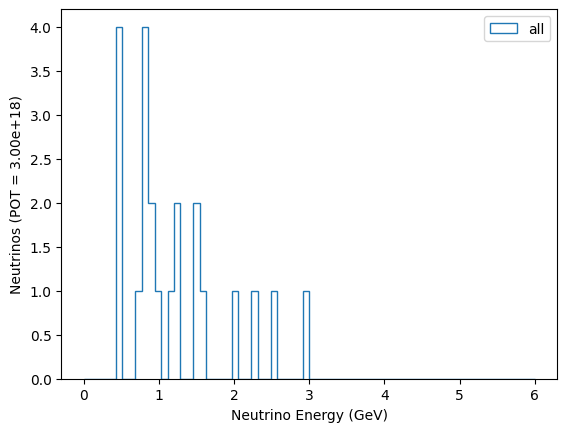

In [52]:
#### 4.2) Draw a plot of nu.E for each slc
plt.hist(nuE_per_slc.E, bins=np.linspace(0., 6., 71), histtype="step", label=["all"])
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel(f"Neutrinos (POT = {target_POT:.2e})")
plt.legend()
plt.show()

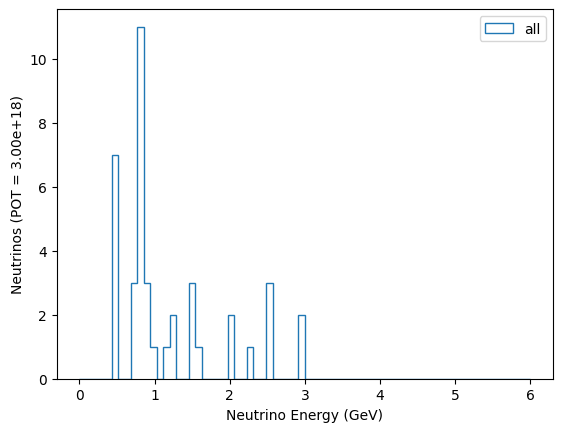

In [55]:
#### 4.3) Draw a plot of nu.E for each slc
###### We can see that some event are double counted where there are multiple pfp objects in a slc
plt.hist(nuE_per_pfp.E, bins=np.linspace(0., 6., 71), histtype="step", label=["all"])
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel(f"Neutrinos (POT = {target_POT:.2e})")
plt.legend()
plt.show()

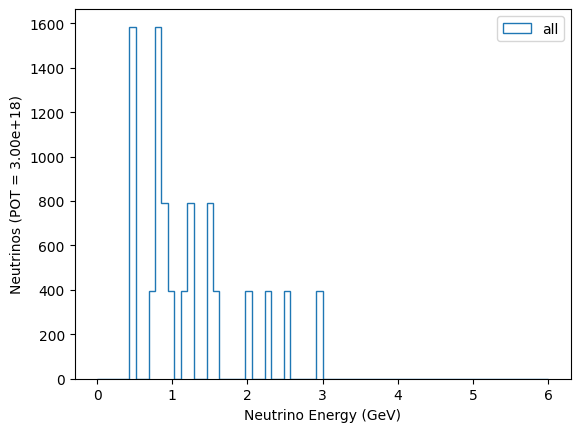

In [54]:
#### 4.4) Draw a plot of nu.E for each slc with POT scaling
plt.hist(nuE_per_slc.E, bins=np.linspace(0., 6., 71), weights=[np.ones_like(data) * POT_scale for data in nuE_per_slc.E], histtype="step", label=["all"])
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel(f"Neutrinos (POT = {target_POT:.2e})")
plt.legend()
plt.show()